In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter

plt.rcParams.update({
    "font.size": 12,          # Base font size
    "axes.titlesize": 12,     # Title size
    "axes.labelsize": 12,     # Axis label size
    "xtick.labelsize": 12,    # X-tick label size
    "ytick.labelsize": 12,    # Y-tick label size
    "legend.fontsize": 12,    # Legend font size
    "figure.titlesize": 12    # Figure title size
})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})


In [6]:
import ipaddress
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

In [7]:
# load all jsons
folder_path = Path("data/packets/sfo")
all_packets = []
all_peers = []

for json_file in folder_path.glob("*.json"):
   with open(json_file, 'r') as f:
       data = json.load(f)
   
   for packet in data['packets']:
        packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

        if not packet['node_data'] is None:
            for k, v in packet['node_data'].items():
                packet_meta[k] = v
        if not packet['payload_data'] is None:
            for k, v in packet['payload_data'].items(): 
                packet_meta[k] = v

        if not packet['local_peerlist_new'] is None:
            packet['peerlist_length'] = len(packet['local_peerlist_new'])
            for peer in packet['local_peerlist_new']:
                peer_data = peer.copy()
                peer_data['source_ip'] = packet['source_ip']
                peer_data['timestamp'] = packet['timestamp']
                peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                all_peers.append(peer_data)

        all_packets.append(packet_meta)

peer_packets_df = pd.DataFrame(all_packets)
peers_df = pd.DataFrame(all_peers)


In [8]:
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['tcp_segments'] = peer_packets_df['tcp_segments'].replace('', 1).astype(int)
peer_packets_df['tcp_length'] = peer_packets_df['tcp_length'].astype(int)
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])

print(peer_packets_df.info())
print(peers_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1373016 entries, 0 to 1373045
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   source_ip                    1373016 non-null  object        
 1   source_port                  1373016 non-null  object        
 2   timestamp                    1373016 non-null  datetime64[ns]
 3   command                      1373016 non-null  object        
 4   monero_flags                 1373016 non-null  object        
 5   tcp_segments                 1373016 non-null  int64         
 6   tcp_length                   1373016 non-null  int64         
 7   cumulative_difficulty        305384 non-null   float64       
 8   cumulative_difficulty_top64  283165 non-null   float64       
 9   current_height               305382 non-null   float64       
 10  top_id                       305384 non-null   object        
 11  top_version     

In [9]:
result_df = peer_packets_df.groupby('source_ip')

# Command Sequence

In [10]:
# connection is treated as idle if unresponsive for 120s -> check based on collected data
# TODO: cite source code 

all_data = peer_packets_df.copy()
all_data = all_data.sort_values(['source_ip', 'timestamp'])
grouped_by_ip = peer_packets_df.groupby('source_ip')

ip_time_diffs = {}
all_time_diffs = []
time_diff_commands = []

for ip, group in grouped_by_ip:
    # Sort by timestamp to ensure correct order
    group_sorted = group.sort_values('timestamp')
    
    # Calculate time differences within this IP group
    time_diffs = group_sorted['timestamp'].diff().dt.total_seconds()
    
    # Remove NaN values (first row of each group) and get corresponding commands
    mask = ~time_diffs.isna()
    time_diffs_clean = time_diffs[mask]
    commands_clean = group_sorted['command'][mask]
    
    if len(time_diffs_clean) > 0:
        ip_time_diffs[ip] = time_diffs_clean.tolist()
        all_time_diffs.extend(time_diffs_clean.tolist())
        time_diff_commands.extend(commands_clean.tolist())

all_time_diffs = np.array(all_time_diffs)
time_diff_commands = np.array(time_diff_commands)

print(f"\n=== Threshold Analysis ===")

# Below 120s
below_120_mask = all_time_diffs <= 120
below_120 = np.sum(below_120_mask)
below_120_commands = time_diff_commands[below_120_mask]

# Between 120-300s
between_120_300_mask = (all_time_diffs > 120) & (all_time_diffs <= 300)
between_120_300 = np.sum(between_120_300_mask)
between_120_300_commands = time_diff_commands[between_120_300_mask]

# Above 300s
above_300_mask = all_time_diffs > 300
above_300 = np.sum(above_300_mask)
above_300_commands = time_diff_commands[above_300_mask]

total = len(all_time_diffs)

print(f"≤ 120s: {below_120} ({below_120/total*100:.1f}%)")
if len(below_120_commands) > 0:
    cmd_counts = pd.Series(below_120_commands).value_counts()
    print(f"  Top commands: {dict(cmd_counts.head())}")

print(f"120s < x ≤ 300s: {between_120_300} ({between_120_300/total*100:.1f}%)")
if len(between_120_300_commands) > 0:
    cmd_counts = pd.Series(between_120_300_commands).value_counts()
    print(f"  Commands: {dict(cmd_counts)}")
    # Show percentages for this range
    cmd_percentages = (cmd_counts / len(between_120_300_commands) * 100).round(1)
    print(f"  Command percentages: {dict(cmd_percentages)}")

print(f"> 300s: {above_300} ({above_300/total*100:.1f}%)")
if len(above_300_commands) > 0:
    cmd_counts = pd.Series(above_300_commands).value_counts()
    print(f"  Commands: {dict(cmd_counts)}")
    # Show percentages for this range
    cmd_percentages = (cmd_counts / len(above_300_commands) * 100).round(1)
    print(f"  Command percentages: {dict(cmd_percentages)}")


=== Threshold Analysis ===
≤ 120s: 1362466 (99.7%)
  Top commands: {'2002': np.int64(952252), '1002': np.int64(272583), '2008': np.int64(68247), '1001': np.int64(22871), '1003': np.int64(21921)}
120s < x ≤ 300s: 399 (0.0%)
  Commands: {'1001': np.int64(246), '1003': np.int64(65), '2002': np.int64(41), '1002': np.int64(36), '2008': np.int64(8), '2003': np.int64(2), '2002,1002': np.int64(1)}
  Command percentages: {'1001': np.float64(61.7), '1003': np.float64(16.3), '2002': np.float64(10.3), '1002': np.float64(9.0), '2008': np.float64(2.0), '2003': np.float64(0.5), '2002,1002': np.float64(0.3)}
> 300s: 3628 (0.3%)
  Commands: {'1001': np.int64(2749), '1003': np.int64(491), '2002': np.int64(295), '1002': np.int64(66), '1001,1003': np.int64(14), '2008': np.int64(10), '1001,2006': np.int64(2), '2001': np.int64(1)}
  Command percentages: {'1001': np.float64(75.8), '1003': np.float64(13.5), '2002': np.float64(8.1), '1002': np.float64(1.8), '1001,1003': np.float64(0.4), '2008': np.float64(0.3

In [11]:
all_data = peer_packets_df.copy()
all_data = all_data.sort_values(['source_ip', 'timestamp'])

all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

# shift to later compare current vs prev IP
all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

# mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna()) | (all_data['command'] == '1001')
all_data['connection_id'] = all_data['is_break'].cumsum()

# filter already for valid conns
grouped = all_data.groupby('connection_id')
connection_sizes = grouped.size()
valid_conns = connection_sizes >= 2
valid_conn_ids = valid_conns[valid_conns].index

single_packet_conns = connection_sizes[connection_sizes == 1]
if len(single_packet_conns) > 0:
    single_packet_data = all_data[all_data['connection_id'].isin(single_packet_conns.index)]
    print(f"Single-packet connections analysis:")
    print(f"  Total: {len(single_packet_conns)}")
    print(f"  Commands: {single_packet_data['command'].value_counts().to_dict()}")
    print(f"  IPs: {single_packet_data['source_ip'].nunique()} unique IPs")
    print(f"  Monero flags: {single_packet_data['monero_flags'].value_counts().to_dict()}")

all_connections = []
for conn_id in valid_conn_ids:
    conn = grouped.get_group(conn_id)
    all_connections.append({
        'id': f"{conn['source_ip'].iloc[0]}_{conn_id}",
        'ip': conn['source_ip'].iloc[0],
        'commands': conn['command'].tolist(),
        'monero_flags': conn['monero_flags'].tolist(),
        'timestamp': conn['timestamp'].tolist(),
        'duration': (conn['timestamp'].iloc[-1] - conn['timestamp'].iloc[0]).total_seconds()
    })
print(len(all_connections))

Single-packet connections analysis:
  Total: 5810
  Commands: {'1001': 4688, '1003': 1068, '1002': 34, '2002': 14, '2008': 5, '2003': 1}
  IPs: 3191 unique IPs
  Monero flags: {'1': 5132, '2': 678}
27611


In [12]:
results = []
all_ts_diffs = []
all_conn_avgs = []
for conn in all_connections:
    # Timed Sync Latency Analysis
    commands = np.array(conn['commands'])
    monero_flags = np.array(conn['monero_flags'])
    timestamps = np.array(conn['timestamp'])

    ts_mask = (commands == '1002') & (monero_flags == '1')
    ts_commands = commands[ts_mask]
    ts_monero_flags = monero_flags[ts_mask]
    ts_series = pd.Series(timestamps[ts_mask])
    
    high_diff = False
    if len(ts_series) > 2:
        differences = ts_series.diff().dt.total_seconds().dropna()
        all_ts_diffs.extend(differences)
        all_conn_avgs.append(differences.mean())
        for diff in differences:
            if diff > 1000:
                high_diff = True
    
    if False: #high_diff == True:
        print(len(commands))
        counts = pd.Series(commands).value_counts().sort_index()
        print(counts)
        print(ts_series)
        break




[60.926914, 61.223455, 60.398464, 60.186647, 60.363659]
[np.float64(62.60713070909092), np.float64(79.91621777551019), np.float64(61.04423700000001), np.float64(62.30745171428571), np.float64(61.80004126415093)]


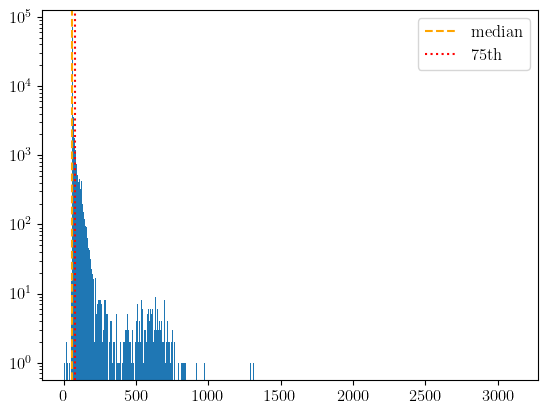

122680 Timed Sync differences.
Averaged over all time differences: 69.1035884676883
Percentile distribution: 
25th percentile: 60.58012975
50th percentile: 61.210616
75th percentile: 65.4737655
90th percentile: 77.64989720000001
95th percentile: 100.80821899999984
99th percentile: 163.0047882799996


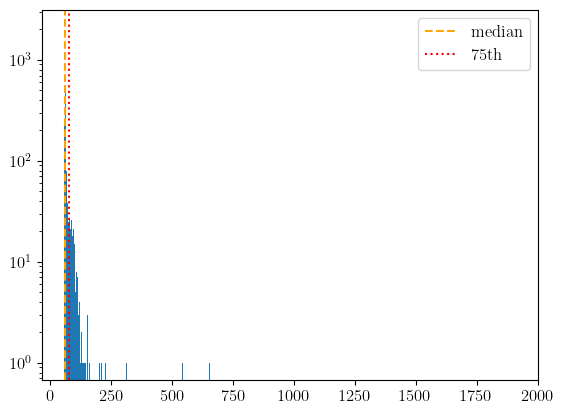

3703 individual connections.
Averaged over the connection averages: 68.08617358722202
Percentile distribution: 
25th percentile: 61.63101900074061
50th percentile: 62.21261105
75th percentile: 63.50235415625001
90th percentile: 79.24341000000001
95th percentile: 93.692184375
99th percentile: 127.5364898


In [13]:
print(f"\n{all_ts_diffs[:5]}")
print(f"{all_conn_avgs[:5]}")

percentiles = [25, 50, 75, 90, 95, 99]

plt.hist(all_ts_diffs, bins=1000, log=True)
#plt.axvline(np.mean(all_ts_diffs), color='red', linestyle='--', label='mean')
plt.axvline(np.median(all_ts_diffs), color='orange', linestyle='--', label='median')
#plt.axvline(np.percentile(all_ts_diffs, 25), color='green', linestyle=':', label='25th')
plt.axvline(np.percentile(all_ts_diffs, 90), color='red', linestyle=':', label='75th')
plt.legend()
plt.show()
print(f"{len(all_ts_diffs)} Timed Sync differences.")
print(f"Averaged over all time differences: {np.mean(all_ts_diffs)}")
print(f"Percentile distribution: ")
for percentile in percentiles:
    print(f"{percentile}th percentile: {np.percentile(all_ts_diffs, percentile)}")

plt.hist(all_conn_avgs, bins=1000, log=True)
#plt.axvline(np.mean(all_conn_avgs), color='red', linestyle='--', label='mean')
plt.axvline(np.median(all_conn_avgs), color='orange', linestyle='--', label='median')
#plt.axvline(np.percentile(all_conn_avgs, 25), color='green', linestyle=':', label='25th')
plt.axvline(np.percentile(all_conn_avgs, 90), color='red', linestyle=':', label='75th')
plt.legend()
plt.show()
print(f"{len(all_conn_avgs)} individual connections.")
print(f"Averaged over the connection averages: {np.mean(all_conn_avgs)}")
print(f"Percentile distribution: ")
for percentile in percentiles:
    print(f"{percentile}th percentile: {np.percentile(all_conn_avgs, percentile)}")

In [14]:
results = []

for conn in all_connections:
    # Timed Sync Analysis
    commands = np.array(conn['commands'])
    monero_flags = np.array(conn['monero_flags'])
    timestamps = np.array(conn['timestamp'])

    result_row = {
            'ip': conn['ip'],
            'connection_id': conn['id'],
            'total_commands': len(commands),
            'commands': commands,
            'duration': conn['duration'],
            'ts_latency': None,
            'tot_pings': None,
            'ping_frequency': None,
            'has_ts_irregularity': False,
            'has_ping_data': False
        }
    
    ts_mask = (commands == '1002') & (monero_flags == '1')
    ts_commands = commands[ts_mask]
    ts_monero_flags = monero_flags[ts_mask]
    ts_series = pd.Series(timestamps[ts_mask])
    if len(ts_series) > 2:
        differences = ts_series.diff().dt.total_seconds().dropna()
        near_60 = differences[(differences <= np.percentile(all_ts_diffs, 75))]         # time diff of all unique ts differences
        outliers = differences[(differences > np.percentile(all_ts_diffs, 95))]
        if len(near_60)/len(differences) < 0.5 and (len(outliers)/len(differences)) > 0.1:
            result_row['ts_latency'] = differences.mean()
            result_row['has_ts_irregularity'] = True
    
    # Ping Analysis
    ping_mask = (commands == '1003')
    ping_timestamps = timestamps[ping_mask]
    if len(ping_timestamps) > 1:
        ping_series = pd.Series(ping_timestamps)
        ping_differences = ping_series.diff().dt.total_seconds().dropna()

        result_row['tot_pings'] = len(ping_timestamps)
        result_row['ping_frequency'] = ping_differences.mean()
        result_row['has_ping_irr'] = True
    
    results.append(result_row)

connection_df = pd.DataFrame(results)
print(f"IPs with Timed Sync delays: {connection_df['has_ts_irregularity'].sum()}")
print(f"Top 5 IPs by highest latency:\n{connection_df.nlargest(5, 'ts_latency')[['ip', 'ts_latency']]}")
print(f"\nMedian ping frequency: {connection_df['ping_frequency'].median():.2f}s")
print(f"Top 5 IPs by ping count:\n{connection_df.nlargest(5, 'tot_pings')[['ip', 'tot_pings', 'duration']]}")

IPs with Timed Sync delays: 368
Top 5 IPs by highest latency:
                   ip   ts_latency
506    12.165.234.249  1908.429981
24379  45.138.183.132   652.812536
24380  45.138.183.132   641.329118
22309   185.148.1.210   630.965920
715     137.220.65.28   545.454911

Median ping frequency: 5.02s
Top 5 IPs by ping count:
                    ip  tot_pings    duration
23525  209.222.252.118       36.0  174.556783
72        100.42.27.97       35.0  173.757272
22852     193.142.4.24       35.0  165.252236
23529  209.222.252.141       32.0  156.914542
23220   199.116.84.219       29.0  172.063453


In [15]:
# for connection visualization focus on IP and dont split the connection for repeated Handshakes (known pattern)
all_data = peer_packets_df.copy()
all_data = all_data.sort_values(['source_ip', 'timestamp'])

all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

# shift to later compare current vs prev IP
all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

# mask logic to identify breaks if IP changes, time is bigger 300s, or first row
all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna())
all_data['connection_id'] = all_data['is_break'].cumsum()

# filter already for valid conns
grouped = all_data.groupby('connection_id')
connection_sizes = grouped.size()
single_packet_conns = connection_sizes[connection_sizes == 1]
if len(single_packet_conns) > 0:
    single_packet_data = all_data[all_data['connection_id'].isin(single_packet_conns.index)]
    print(f"Single-packet connections analysis:")
    print(f"  Total: {len(single_packet_conns)}")
    print(f"  Commands: {single_packet_data['command'].value_counts().to_dict()}")
    print(f"  IPs: {single_packet_data['source_ip'].nunique()} unique IPs")
    print(f"  Monero flags: {single_packet_data['monero_flags'].value_counts().to_dict()}")

Single-packet connections analysis:
  Total: 3254
  Commands: {'1001': 3023, '1003': 192, '1002': 23, '2002': 11, '2008': 5}
  IPs: 2605 unique IPs
  Monero flags: {'1': 3127, '2': 127}


In [ ]:
# for connection visualization focus on IP and dont split the connection for repeated Handshakes (known pattern)
all_data = peer_packets_df.copy()
all_data = all_data.sort_values(['source_ip', 'timestamp'])

all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

# shift to later compare current vs prev IP
all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

# mask logic to identify breaks if IP changes, time is bigger 300s, or first row
all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna())
all_data['connection_id'] = all_data['is_break'].cumsum()

# filter already for valid conns
grouped = all_data.groupby('connection_id')
connection_sizes = grouped.size()
valid_conns = connection_sizes >= 30
valid_conn_ids = valid_conns[valid_conns].index

all_connections = []
all_sequences = []
max_length = 0

for conn_id in valid_conn_ids:
    conn = grouped.get_group(conn_id)
    p2p_commands = [int(x) for x in conn['command'].tolist() if x in ['1001', '1002', '1003']]
    all_sequences.append(p2p_commands)
    max_length = max(max_length, len(p2p_commands))

print(f"Found {len(all_sequences)} sequences with P2P commands")
print(f"Maximum sequence length: {max_length}")

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: All sequences overlaid with transparency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green for 1001, 1002, 1003
command_to_color = {1001: colors[0], 1002: colors[1], 1003: colors[2]}

frequency_matrix = {}
all_points = []  # Store all points for batch processing

print(f"Processing {len(all_sequences)} sequences for visualization...")

for sequence in all_sequences:
    truncated_sequence = sequence[:30]
    for pos, cmd in enumerate(truncated_sequence):
        key = (pos, cmd)
        frequency_matrix[key] = frequency_matrix.get(key, 0) + 1
        all_points.append((pos, cmd))

# Calculate max frequency for normalization
max_freq = max(frequency_matrix.values()) if frequency_matrix else 1

# Group points by (position, command) for efficient plotting
from collections import defaultdict
point_groups = defaultdict(list)

for sequence_idx, sequence in enumerate(all_sequences):
    truncated_sequence = sequence[:30]
    for pos, cmd in enumerate(truncated_sequence):
        point_groups[(pos, cmd)].append(sequence_idx)

# Plot each unique (position, command) combination once with appropriate styling
for (pos, cmd), sequence_indices in point_groups.items():
    freq = len(sequence_indices)  # This is the frequency at this position-command
    normalized_freq = freq / max_freq
    
    # Calculate visual properties based on frequency
    size = 15 + (normalized_freq * 35)  # Range: 15-50
    alpha = 0.3 + (normalized_freq * 0.6)  # Range: 0.3-0.9
    
    # Plot all points of this type at once
    ax1.scatter(pos, cmd, c=command_to_color[cmd], 
               s=size, alpha=alpha, edgecolors='white', linewidth=0.5)

# Add connecting lines for sequences (simplified approach)
# Sample a subset of sequences for line visualization to avoid overcrowding
import random
sample_size = min(100, len(all_sequences))  # Limit to 100 sequences for lines
sampled_sequences = random.sample(all_sequences, sample_size)

for sequence in sampled_sequences:
    truncated_sequence = sequence[:30]
    if len(truncated_sequence) > 1:
        x_positions = list(range(len(truncated_sequence)))
        y_positions = truncated_sequence
        
        # Use a single alpha for the entire line
        ax1.plot(x_positions, y_positions, color='gray', alpha=0.1, linewidth=0.5)

print(f"Plotted {len(point_groups)} unique position-command combinations")
print(f"Added connecting lines for {len(sampled_sequences)} sample sequences")

ax1.set_xlabel('Position in Sequence')
ax1.set_ylabel('Command Value')
ax1.set_title('P2P Command Sequences Overlay (First 50 commands per sequence)')
ax1.set_yticks([1001, 1002, 1003])
ax1.set_yticklabels(['1001', '1002', '1003'])
ax1.grid(True, alpha=0.3)
ax1.legend(['1001', '1002', '1003'], loc='upper right')

# Plot 2: Heatmap showing command frequency by position
# Create a matrix where rows are positions and columns are command types
max_positions = 30
position_command_matrix = np.zeros((max_positions, 3))

for sequence in all_sequences:
    for pos, cmd in enumerate(sequence[:30]):
        if cmd == 1001:
            position_command_matrix[pos, 0] += 1
        elif cmd == 1002:
            position_command_matrix[pos, 1] += 1
        elif cmd == 1003:
            position_command_matrix[pos, 2] += 1

log_matrix = np.log10(position_command_matrix + 1)

im = ax2.imshow(log_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Position in Sequence')
ax2.set_ylabel('Command Type')
ax2.set_title('Command Frequency Heatmap by Position')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['1001', '1002', '1003'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Log10(Frequency + 1)')

plt.tight_layout()
plt.show()

# Print some statistics
print("\n=== Statistics ===")
all_commands = [cmd for seq in all_sequences for cmd in seq]
command_counts = Counter(all_commands)
print(f"Total commands: {len(all_commands)}")
print(f"Command distribution: {dict(command_counts)}")

# Show length distribution
lengths = [len(seq) for seq in all_sequences]
print(f"Sequence length stats:")
print(f"  Mean: {np.mean(lengths):.2f}")
print(f"  Median: {np.median(lengths):.2f}")
print(f"  Min: {min(lengths)}, Max: {max(lengths)}")

# Peer Lists

In [ ]:
unique_peers_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.unique().tolist()).reset_index()
unique_peers_by_source.columns = ['source_ip', 'unique_peer_ips']
#print(unique_peers_by_source.head())

unique_peers_by_source['peer_count'] = unique_peers_by_source['unique_peer_ips'].apply(len)
unique_peers_by_source = unique_peers_by_source[unique_peers_by_source['peer_count'] > 250]

# Analyze sizes
peer_counts = unique_peers_by_source.set_index('source_ip')['peer_count']
print("Peer list size statistics:")
print(peer_counts.describe())
print(f"\nTop 5 sources by peer count:")
print(peer_counts.nlargest(5))

# Analyze overlap between sources
from itertools import combinations

# Convert to dict for easier access
peer_sets = {row['source_ip']: set(row['unique_peer_ips']) 
            for _, row in unique_peers_by_source.iterrows()}

# Calculate pairwise overlaps
overlaps = []
for source1, source2 in combinations(peer_sets.keys(), 2):
   intersection = len(peer_sets[source1] & peer_sets[source2])
   union = len(peer_sets[source1] | peer_sets[source2])
   jaccard = intersection / union if union > 0 else 0
   
   overlaps.append({
       'source1': source1, 'source2': source2,
       'intersection': intersection, 'jaccard_similarity': jaccard,
       'union': union
   })

overlap_df = pd.DataFrame(overlaps)
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(5, 'intersection')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])
#print(f"\nSmallest overlaps:")
#print(overlap_df.nsmallest(5, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(15, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])

In [ ]:
all_ips_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.tolist()).reset_index()
#print(all_ips_by_source.head(5))

rows = []
    
for _, row in all_ips_by_source.iterrows():
    source_ip = row['source_ip']
    ip_list = row['ip']
    
    # Count occurrences of each IP for this source
    ip_counts = Counter(ip_list)
    
    # Create rows for each unique IP
    for ip, count in ip_counts.items():
        rows.append({
            'source_ip': source_ip,
            'target_ip': ip,
            'count': count,
            'total_ips_in_source': len(ip_list),
            'unique_ips_in_source': len(ip_counts)
        })

ip_analysis_df = pd.DataFrame(rows)

source_summary = ip_analysis_df.groupby('source_ip').agg({
    'target_ip': 'nunique',  # unique IPs per source
    'count': ['sum', 'mean', 'max', 'std'],  # count statistics
    'total_ips_in_source': 'first'
}).round(2)

source_summary.columns = ['unique_target_ips', 'total_connections', 
                         'avg_ip_frequency', 'max_ip_frequency', 
                         'std_ip_frequency', 'total_ips_in_list']

print("SOURCE IP ANALYSIS:")
columns = ['avg_ip_frequency', 'max_ip_frequency']
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
for c in columns: 
    print(f"\nMax {c}: {source_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {source_summary[c].quantile(q)}"))
#print(source_summary.head())

source_summary['avg_ip_frequency'].hist(bins=10, alpha=0.7, log=True)
plt.axvline(source_summary["avg_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

source_summary['max_ip_frequency'].hist(bins=100, alpha=0.7, log=True)
plt.axvline(source_summary["max_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary = ip_analysis_df.groupby('target_ip').agg({
    'source_ip': 'nunique',  # in how many sources this IP appears
    'count': ['sum', 'mean', 'max'],  # frequency statistics
}).round(2)

target_summary.columns = ['appears_in_n_sources', 'total_occurrences', 
                         'avg_frequency_per_source', 'max_frequency_in_source']

print("TARGET IP ANALYSIS:")

columns = ["avg_frequency_per_source", "max_frequency_in_source"]
for c in columns: 
    print(f"\nMax {c}: {target_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {target_summary[c].quantile(q)}"))
#print(target_summary.sort_values('total_occurrences', ascending=False).head())
target_summary["avg_frequency_per_source"].hist(bins=10, alpha=0.7, log=True)
plt.axvline(target_summary["avg_frequency_per_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary["max_frequency_in_source"].hist(bins=100, alpha=0.7, log=True)
plt.axvline(target_summary["max_frequency_in_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

distribution_stats = {
    'total_unique_target_ips': ip_analysis_df['target_ip'].nunique(),
    'total_unique_source_ips': ip_analysis_df['source_ip'].nunique(),
    'avg_connections_per_source': ip_analysis_df.groupby('source_ip')['count'].sum().mean(),
    'avg_unique_ips_per_source': ip_analysis_df.groupby('source_ip')['target_ip'].nunique().mean(),
}

print("DISTRIBUTION STATISTICS:")
for key, value in distribution_stats.items():
    print(f"{key}: {value:.2f}")



In [ ]:
SIMILARITY_THRESHOLD = 0.2 # tbd
high_sim_pairs = overlap_df[overlap_df['jaccard_similarity'] >= SIMILARITY_THRESHOLD].copy()
print(high_sim_pairs.head())

groups = []

for _, row in high_sim_pairs.iterrows():
    source1, source2 = row['source1'], row['source2']
    sim = row['jaccard_similarity']

    found_group = None
    for group in groups:
        if source1 in group['sources'] or source2 in group['sources']:
            found_group = group
            break
    
    if not found_group is None:
        found_group['sources'].add(source1)
        found_group['sources'].add(source2)
        found_group['similarities'].append(sim)
    else:
        groups.append({
            'sources': {source1, source2},
            'similarities': [sim]
        })
    
final_groups = []
for group in groups:
    if len(group['sources']) > 1:
        sources_list = list(group['sources'])
        similarities = group['similarities']
        final_groups.append({
            'sources': sources_list,
            'avg_similarity': sum(similarities) / len(similarities),
            'min_similarity': min(similarities),
            'max_similarity': max(similarities),
            'num_pairs': len(similarities)
        })

print(f"\nFound {len(final_groups)} similarity groups.\nMost similar groups: ")
for i, group in enumerate(final_groups, 1):
    if group['avg_similarity'] > 0.65:
        print(f"Group {i} ({len(group['sources'])} sources):")
        print(f"  Sources: {group['sources']}")
        print(f"  Avg similarity: {group['avg_similarity']:.3f}")
        print(f"  Range: {group['min_similarity']:.3f} - {group['max_similarity']:.3f}")
        print(f"  Based on {group['num_pairs']} pairs")

if final_groups:
    group_sizes = [len(group['sources']) for group in final_groups]
    avg_similarities = [group['avg_similarity'] for group in final_groups]
    print(f"\nOverall stats:")
    print(f"Total sources in groups: {sum(group_sizes)}")
    print(f"Average group size: {sum(group_sizes)/len(group_sizes):.1f}")
    print(f"Largest group: {max(group_sizes)} sources")
    print(f"Average of group similarities: {sum(avg_similarities)/len(avg_similarities):.3f}")

# Subnets

In [ ]:
# subnet analysis
unique_peers_by_source['unique_subnets'] = unique_peers_by_source['unique_peer_ips'].apply(
   lambda ip_list: list(set([ip_to_subnet(ip) for ip in ip_list if ip_to_subnet(ip) is not None]))
)

unique_peers_by_source['subnet_count'] = unique_peers_by_source['unique_subnets'].apply(len)

# ratio: unique peers / unique subnets
unique_peers_by_source['peers_per_subnet_ratio'] = (
   unique_peers_by_source['peer_count'] / unique_peers_by_source['subnet_count']
)
unique_peers_by_source.info()
print(unique_peers_by_source['peers_per_subnet_ratio'].max())

In [ ]:
all_peer_subnets = []
for _, row in unique_peers_by_source.iterrows():
   for ip in row['unique_peer_ips']:
       subnet = ip_to_subnet(ip)
       if subnet:
           all_peer_subnets.append({'ip': ip, 'subnet': subnet, 'source_ip': row['source_ip']})

print("Most populated subnets:")
peer_subnet_df = pd.DataFrame(all_peer_subnets)
peers_per_subnet = peer_subnet_df.groupby('subnet')['ip'].nunique().reset_index()
peers_per_subnet.columns = ['subnet', 'unique_peer_count']
peers_per_subnet = peers_per_subnet.sort_values('unique_peer_count', ascending=False)
print(peers_per_subnet.head(20))